<a href="https://colab.research.google.com/github/SavchukDI/3d_ml_mai/blob/main/3dml_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install redner-gpu

     |████████████████████████████████| 31.8 MB 290 kB/s 


In [2]:
import torch
import pyredner
import h5py
import urllib
import time

from matplotlib.pyplot import imshow
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import animation

from IPython.display import HTML

In [13]:
# Load the Basel face model
with h5py.File(r'/content/drive/MyDrive/Colab_Notebooks/3D_ML/data/model2017-1_bfm_nomouth.h5', 'r') as hf:
    shape_mean = torch.tensor(hf['shape/model/mean'], 
                              device = pyredner.get_device())
    shape_basis = torch.tensor(hf['shape/model/pcaBasis'], 
                               device = pyredner.get_device())
    triangle_list = torch.tensor(hf['shape/representer/cells'], 
                                 device = pyredner.get_device())
    color_mean = torch.tensor(hf['color/model/mean'], 
                              device = pyredner.get_device())
    color_basis = torch.tensor(hf['color/model/pcaBasis'], 
                               device = pyredner.get_device())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [14]:
indices = triangle_list.permute(1, 0).contiguous()

def model(
        cam_pos, 
        cam_look_at, 
        shape_coeffs, 
        color_coeffs, 
        ambient_color, 
        dir_light_intensity):
    vertices = (shape_mean + shape_basis @ shape_coeffs).view(-1, 3)
    normals = pyredner.compute_vertex_normal(vertices, indices)
    colors = (color_mean + color_basis @ color_coeffs).view(-1, 3)
    m = pyredner.Material(use_vertex_color = True)
    obj = pyredner.Object(vertices = vertices, 
                          indices = indices, 
                          normals = normals, 
                          material = m, 
                          colors = colors)
    cam = pyredner.Camera(position = cam_pos,
                          # Center of the vertices                          
                          look_at = cam_look_at,
                          up = torch.tensor([0.0, 1.0, 0.0]),
                          fov = torch.tensor([45.0]),
                          resolution = (256, 256))
    scene = pyredner.Scene(camera = cam, objects = [obj])
    ambient_light = pyredner.AmbientLight(ambient_color)
    dir_light = pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0]), 
                                          dir_light_intensity)
    img = pyredner.render_deferred(scene = scene, 
                                   lights = [ambient_light, dir_light])
    return img

/usr/local/lib/python3.7/dist-packages/pyredner/render_pytorch.py:55: UserWarning: Converting texture from cpu to cuda:0, this can be inefficient.
  warnings.warn('Converting texture from {} to {}, this can be inefficient.'.format(mipmap.device, device))


Scene construction, time: 0.13003 s
Forward pass, time: 0.35949 s


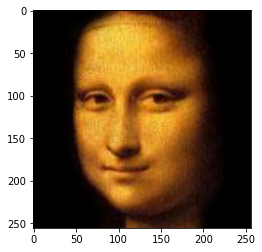

In [15]:

cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277])
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918])
img = model(cam_pos, 
            cam_look_at, 
            torch.zeros(199, device = pyredner.get_device()),
            torch.zeros(199, device = pyredner.get_device()),
            torch.ones(3), 
            torch.zeros(3))

imshow(torch.pow(img, 1.0/2.2).cpu())

face_url = 'https://raw.githubusercontent.com/BachiLi/redner/master/tutorials/mona-lisa-cropped-256.png'

urllib.request.urlretrieve(face_url, 'target.png')
target = pyredner.imread('target.png').to(pyredner.get_device())

imshow(torch.pow(target, 1.0/2.2).cpu())

In [16]:
# Set requires_grad=True since we want to optimize them later
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], 
                       requires_grad=True)
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], 
                           requires_grad=True)
shape_coeffs = torch.zeros(199, device = pyredner.get_device(), 
                           requires_grad=True)
color_coeffs = torch.zeros(199, device = pyredner.get_device(), 
                           requires_grad=True)
ambient_color = torch.ones(3, device = pyredner.get_device(), 
                           requires_grad=True)
dir_light_intensity = torch.zeros(3, device = pyredner.get_device(), 
                                  requires_grad=True)

# Use two different optimizers for different learning rates
optimizer = torch.optim.Adam(
                             [
                              shape_coeffs, 
                              color_coeffs, 
                              ambient_color, 
                              dir_light_intensity], 
                             lr=0.1)
cam_optimizer = torch.optim.Adam([cam_pos, cam_look_at], lr=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


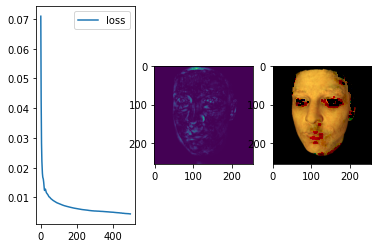

In [18]:
plt.figure()
imgs, losses = [], []

# Run 500 Adam iterations
num_iters = 500
for t in range(num_iters):
    optimizer.zero_grad()
    cam_optimizer.zero_grad()
    img = model(cam_pos, cam_look_at, shape_coeffs, 
                color_coeffs, ambient_color, dir_light_intensity)
    # Compute the loss function. Here it is L2 plus a regularization 
    # term to avoid coefficients to be too far from zero.
    # Both img and target are in linear color space, 
    # so no gamma correction is needed.

    loss = (img - target).pow(2).mean()
    loss = loss + 0.0001 * shape_coeffs.pow(2).mean() + 0.001 * color_coeffs.pow(2).mean()
    loss.backward()

    optimizer.step()
    cam_optimizer.step()

    ambient_color.data.clamp_(0.0)
    dir_light_intensity.data.clamp_(0.0)

    # Plot the loss
    f, (ax_loss, ax_diff_img, ax_img) = plt.subplots(1, 3)
    losses.append(loss.data.item())

    # Only store images every 10th iterations
    if t % 10 == 0:
        # Record the Gamma corrected image
        imgs.append(torch.pow(img.data, 1.0/2.2).cpu()) 
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_diff_img.imshow((img -target).pow(2).sum(dim=2).data.cpu())
    ax_img.imshow(torch.pow(img.data.cpu(), 1.0/2.2))
    plt.show()

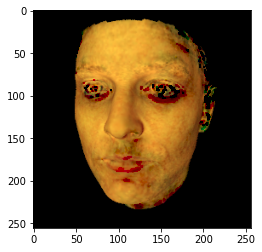

In [19]:
fig = plt.figure()

# Clamp to avoid complains
im = plt.imshow(imgs[0].clamp(0.0, 1.0), animated=True)

def update_fig(i):
    im.set_array(imgs[i].clamp(0.0, 1.0))
    return im,
anim = animation.FuncAnimation(fig, update_fig, 
                               frames=len(imgs), interval=50, blit=True)
HTML(anim.to_jshtml())